# Common Test 1: Multi-Class Classification

### Name: Shashwat Srivastava
### Project: DeepLense
### Evaluation Test Notebook

### Importing necessary libraries

In [2]:
# File navigation
import os
from pathlib import Path

# Neural network
import torch
from torch import nn, Tensor
from torchvision.models import efficientnet_b0

# Data pipeline and cleaning
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
from torchvision.transforms import Compose, Lambda, functional

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Metrics
from sklearn.metrics import RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Miscellaneous
import numpy as np
import pandas as pd
from torchsummary import summary
from tqdm import tqdm
from typing import List, Tuple

### Basic settings

In [3]:
plt.style.use('dark_background')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Device being used: {device}')

Device being used: mps


### Utility functions

In [4]:
# Centre cropping image to reduce size
transforms = Compose([Lambda (lambda x:functional.crop(torch.tensor(x),20,20,100,100))])

# Function to calculate accuracy
a=lambda diff: sum(torch.logical_not(diff.to(torch.bool)).to(torch.int64)).item()

### Data Visuallization

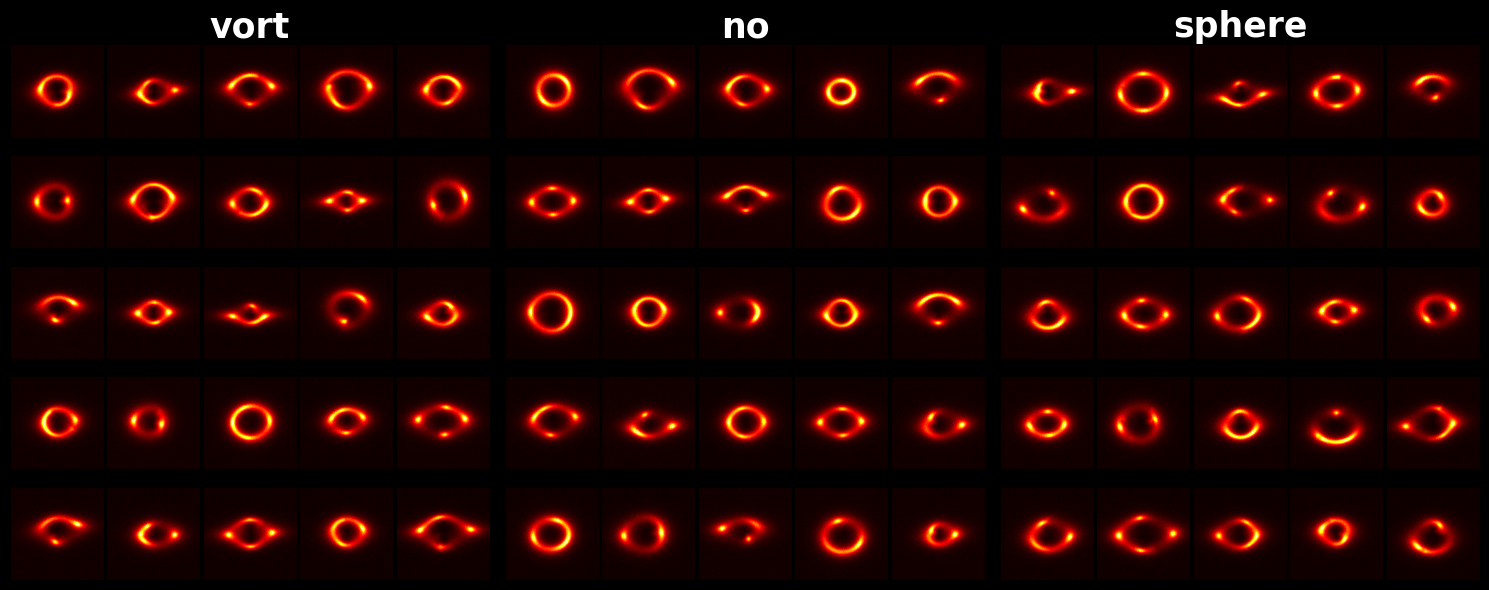

In [5]:
# Loading data
path=Path('datasets/Common Task 1/train')
dirs = [i for i in path.iterdir() if i.name in ['no', 'vort', 'sphere']]
fig = plt.figure(figsize = (15,6))
iax = gridspec.GridSpec(1, 3, figure=fig)

grid = 5 # no. of images in each row and column of the grid (can be changed to anything)

# Plotting grid
for ax, cls in zip(iax, dirs):
    out_ax = fig.add_subplot(ax)
    out_ax.set_title(f'{cls.name}', fontsize=25, fontweight='bold')
    out_ax.axis('off')
    jax = gridspec.GridSpecFromSubplotSpec(grid, grid, subplot_spec=ax)
    for i, img in zip(range(grid**2), cls.glob('*.npy')):
        in_ax = fig.add_subplot(jax[i//grid, i%grid])
        in_ax.imshow(np.load(img)[0], cmap='hot')
        in_ax.axis('off')
plt.tight_layout()

### Data Pipeline

In [7]:
class data(Dataset):
    
    def __init__(self, loader_set: str, transforms: Compose = None) -> None:
        
        self.label: dict = {'no':0,'sphere':1,'vort':2} # Labeling the classes
        self.path: Path = Path.cwd()/'datasets'/'Common Task 1'/('val' if loader_set=='test' else 'train') # Path object
        
        # Creating path and corresponding label pair
        self.path_label_pair: List[tuple] = [(file,self.label[file.parent.name]) for file in self.path.glob('*/*.npy')]

        # train/test/val splitting based on choice
        if loader_set == 'test':
            self.loader: List[tuple] = self.path_label_pair
        else:
            self.t, self.v = random_split(self.path_label_pair, [0.9,0.1])
            self.loader: Subset = self.t if loader_set=='train' else self.v
        
        self.transform = transforms # image transforms
        
    def __len__(self) -> int:
        return len(self.loader)
    
    def __getitem__(self, i: int) -> Tuple[Tensor, int]:
        return self.transform(np.load(self.loader[i][0]).astype(np.float32)), self.loader[i][1]

### Data Loaders

In [8]:
train_loader = DataLoader(data('train', transforms), batch_size=128, shuffle=True)
val_loader = DataLoader(data('val', transforms), batch_size=128, shuffle=True)
test_loader = DataLoader(data('test', transforms), batch_size=1, shuffle=True)

### Model architecture

The model used is EfficientNet model pretrained on ImageNet dataset. Reason for choosing this model is that it finds the optimal combination of width, depth and resolution via grid search which extracts the feature maps efficiently and recognises complex patterns. I also tried other models like vanilla CNN, ResNet etc but the performance was not significant. The reason might be that the dataset has a complex pattern that can only be recognised with deep networks and long training time. Both of these stand as a limitation to me (due to limited GPU access). EfficientNet tackles both of these limitations and boosts performance significantly. No parameters of the network were freezed, all were updated in the training but the initialization was from pretrained weights on ImageNet dataset.

In [150]:
model = efficientnet_b0(pretrained=True)

# Adding additional classifier layer
model = nn.Sequential(nn.Conv2d(1,3,1,1,0),
                      model,nn.Linear(1000,3),
                      nn.LogSoftmax(1))

summary(model,(1,90,90)) # Architecture summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 90, 90]               6
            Conv2d-2           [-1, 32, 45, 45]             864
       BatchNorm2d-3           [-1, 32, 45, 45]              64
              SiLU-4           [-1, 32, 45, 45]               0
            Conv2d-5           [-1, 32, 45, 45]             288
       BatchNorm2d-6           [-1, 32, 45, 45]              64
              SiLU-7           [-1, 32, 45, 45]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
SqueezeExcitation-13           [-1, 32, 45, 45]               0
           Conv2d-14           [-1, 16,

### Training initialization

In [165]:
model.to(device)                                             # Sending model to device
model.train()                                                # setting model to training mode
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
l = nn.NLLLoss()                                             # Negative log likelihood loss
metrics = [[] for _ in range(4)]                             # for storing metrics throughout training 
epochs = 50

### Training

In [7]:
for epoch in range(epochs):
    L, A = 0, 0
    for i, (img, label) in enumerate(tqdm(train_loader, desc = f'Epoch: {epoch+1}/{epochs} Training', ncols = 100)):
        
        optimizer.zero_grad()                  # initializing gradients to zero
        y_pred: Tensor = model(img.to(device)) # model prediction
        loss = l(y_pred,label.to(device))      # NLL loss calculation
        loss.backward()                        # Backpropagation (gradient calculation)
        
        with torch.no_grad():
            optimizer.step()                                           # one step towards steepest gradient
            L+=loss.item()                                             # loss accumulation
            A+=a(torch.argmax(y_pred,1)-label.to(device))/len(y_pred)  # accuracy accumulation
            
    with torch.no_grad():
        metrics[0].append(L/(i+1))   # Saving mean loss
        metrics[1].append(A/(i+1))   # Saving mean accuracy

        # Validation
        L, A=0, 0
        for i,(img,label) in enumerate(tqdm(val_loader,desc=f'Epoch: {epoch+1}/{epochs} Validate',ncols=100)):
            y=model(img.to(device))
            loss=l(y,label.to(device))
            L+=loss.item()
            A+=a(torch.argmax(y,1)-label.to(device))/len(y)
        metrics[2].append(L/(i+1))
        metrics[3].append(A/(i+1))

    # Printing epoch metrics
    print (f'train loss: {metrics[0][-1]:.10f}\ttrain acc: {metrics[1][-1]:.10f}\tval loss: {metrics[2][-1]:.10f}\tval acc: {metrics[3][-1]:.10f}\n')

Epoch: 1/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:07<00:00,  3.18it/s]


train loss: 1.1280898279	train acc: 0.3824348341	val loss: 1.0249388938	val acc: 0.4585658482



Epoch: 2/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:10<00:00,  2.31it/s]


train loss: 1.0049491516	train acc: 0.4766365521	val loss: 0.9377657026	val acc: 0.5334821429



Epoch: 3/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:08<00:00,  2.89it/s]


train loss: 0.8983599335	train acc: 0.5652251185	val loss: 0.8400927236	val acc: 0.6074683780



Epoch: 4/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:07<00:00,  3.22it/s]


train loss: 0.7986750346	train acc: 0.6248617694	val loss: 0.7372596438	val acc: 0.6602492560



Epoch: 5/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:08<00:00,  2.68it/s]


train loss: 0.7043792408	train acc: 0.6810426540	val loss: 0.6666765586	val acc: 0.7134951637



Epoch: 6/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:07<00:00,  3.12it/s]


train loss: 0.6208075966	train acc: 0.7237065561	val loss: 0.5855203445	val acc: 0.7566964286



Epoch: 7/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:07<00:00,  3.32it/s]


train loss: 0.5414600855	train acc: 0.7649017575	val loss: 0.4858384418	val acc: 0.8006417411



Epoch: 8/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:11<00:00,  2.10it/s]


train loss: 0.4702137565	train acc: 0.7992619471	val loss: 0.4347367572	val acc: 0.8300781250



Epoch: 9/50 Validate: 100%|█████████████████████████████████████████| 24/24 [00:07<00:00,  3.07it/s]


train loss: 0.4055647241	train acc: 0.8325854068	val loss: 0.4013743487	val acc: 0.8466796875



Epoch: 10/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.97it/s]


train loss: 0.3397887831	train acc: 0.8597970972	val loss: 0.3675942458	val acc: 0.8671875000



Epoch: 11/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.26it/s]


train loss: 0.2924834560	train acc: 0.8823040087	val loss: 0.3458258131	val acc: 0.8827659970



Epoch: 12/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


train loss: 0.2500240957	train acc: 0.9002172196	val loss: 0.3126651191	val acc: 0.8851376488



Epoch: 13/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.01it/s]


train loss: 0.2228579076	train acc: 0.9118730253	val loss: 0.2990842958	val acc: 0.9001581101



Epoch: 14/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:09<00:00,  2.45it/s]


train loss: 0.1937276819	train acc: 0.9233387638	val loss: 0.2879387004	val acc: 0.9057849702



Epoch: 15/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.24it/s]


train loss: 0.1873002425	train acc: 0.9247482227	val loss: 0.2807358888	val acc: 0.9069940476



Epoch: 16/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.80it/s]


train loss: 0.1668422414	train acc: 0.9343058847	val loss: 0.2963937285	val acc: 0.9075055804



Epoch: 17/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:11<00:00,  2.09it/s]


train loss: 0.1581994691	train acc: 0.9379665284	val loss: 0.2730481743	val acc: 0.9157366071



Epoch: 18/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.28it/s]


train loss: 0.1499307661	train acc: 0.9408545616	val loss: 0.2772281033	val acc: 0.9182942708



Epoch: 19/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.31it/s]


train loss: 0.1381872546	train acc: 0.9469687994	val loss: 0.2417607829	val acc: 0.9271298363



Epoch: 20/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:09<00:00,  2.51it/s]


train loss: 0.1353697528	train acc: 0.9480721761	val loss: 0.2806260201	val acc: 0.9258742560



Epoch: 21/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.19it/s]


train loss: 0.1183440639	train acc: 0.9547047788	val loss: 0.2818633355	val acc: 0.9249906994



Epoch: 22/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.25it/s]


train loss: 0.1188786037	train acc: 0.9534829186	val loss: 0.2652995686	val acc: 0.9242466518



Epoch: 23/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:10<00:00,  2.40it/s]


train loss: 0.1152306506	train acc: 0.9539988152	val loss: 0.2419027494	val acc: 0.9328031994



Epoch: 24/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:09<00:00,  2.48it/s]


train loss: 0.1095719405	train acc: 0.9570448262	val loss: 0.2718649860	val acc: 0.9304315476



Epoch: 25/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.10it/s]


train loss: 0.1010385500	train acc: 0.9611102883	val loss: 0.2673784420	val acc: 0.9313151042



Epoch: 26/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.93it/s]


train loss: 0.0974850339	train acc: 0.9618187204	val loss: 0.2495280365	val acc: 0.9363839286



Epoch: 27/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:09<00:00,  2.59it/s]


train loss: 0.0989751568	train acc: 0.9615990324	val loss: 0.2619956965	val acc: 0.9354538690



Epoch: 28/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.32it/s]


train loss: 0.0966375181	train acc: 0.9623247433	val loss: 0.2483835987	val acc: 0.9302920387



Epoch: 29/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.79it/s]


train loss: 0.0962571932	train acc: 0.9628184242	val loss: 0.2723373440	val acc: 0.9331752232



Epoch: 30/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.97it/s]


train loss: 0.0859596081	train acc: 0.9666691351	val loss: 0.2684591236	val acc: 0.9360119048



Epoch: 31/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.24it/s]


train loss: 0.0884395612	train acc: 0.9663359005	val loss: 0.2806734322	val acc: 0.9323846726



Epoch: 32/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.36it/s]


train loss: 0.0831390859	train acc: 0.9679181477	val loss: 0.2386272553	val acc: 0.9388485863



Epoch: 33/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.69it/s]


train loss: 0.0844436324	train acc: 0.9663729265	val loss: 0.2796274020	val acc: 0.9368024554



Epoch: 34/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.95it/s]


train loss: 0.0844193734	train acc: 0.9699965442	val loss: 0.2456013237	val acc: 0.9421968006



Epoch: 35/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.75it/s]


train loss: 0.0798163805	train acc: 0.9684044234	val loss: 0.2329090286	val acc: 0.9378720238



Epoch: 36/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.08it/s]


train loss: 0.0733063643	train acc: 0.9723711493	val loss: 0.2324339269	val acc: 0.9464285714



Epoch: 37/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.96it/s]


train loss: 0.0730835922	train acc: 0.9729956556	val loss: 0.2468032061	val acc: 0.9372209821



Epoch: 38/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.35it/s]


train loss: 0.0712109051	train acc: 0.9729290087	val loss: 0.2937306343	val acc: 0.9373604911



Epoch: 39/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.09it/s]


train loss: 0.0711137049	train acc: 0.9712924566	val loss: 0.2607084938	val acc: 0.9487537202



Epoch: 40/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.91it/s]


train loss: 0.0699693781	train acc: 0.9735238942	val loss: 0.2728554864	val acc: 0.9435918899



Epoch: 41/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.93it/s]


train loss: 0.0705603422	train acc: 0.9725834321	val loss: 0.2803129523	val acc: 0.9387555804



Epoch: 42/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.18it/s]


train loss: 0.0714190285	train acc: 0.9725167852	val loss: 0.2695892885	val acc: 0.9395926339



Epoch: 43/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.23it/s]


train loss: 0.0624449122	train acc: 0.9753727291	val loss: 0.2486792952	val acc: 0.9521949405



Epoch: 44/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.01it/s]


train loss: 0.0613526424	train acc: 0.9758540679	val loss: 0.2254599795	val acc: 0.9512183780



Epoch: 45/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.86it/s]


train loss: 0.0688430128	train acc: 0.9741039692	val loss: 0.2460840329	val acc: 0.9460100446



Epoch: 46/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.80it/s]


train loss: 0.0631249478	train acc: 0.9759997038	val loss: 0.2248799407	val acc: 0.9463355655



Epoch: 47/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:07<00:00,  3.04it/s]


train loss: 0.0607306205	train acc: 0.9763280016	val loss: 0.2447507066	val acc: 0.9473121280



Epoch: 48/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.70it/s]


train loss: 0.0630801109	train acc: 0.9766661730	val loss: 0.2458625740	val acc: 0.9494977679



Epoch: 49/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.89it/s]


train loss: 0.0561917673	train acc: 0.9780065166	val loss: 0.2395086149	val acc: 0.9521949405



Epoch: 50/50 Validate: 100%|████████████████████████████████████████| 24/24 [00:08<00:00,  2.76it/s]

train loss: 0.0577058807	train acc: 0.9777029028	val loss: 0.2450404499	val acc: 0.9542875744



### Plotting training metrics

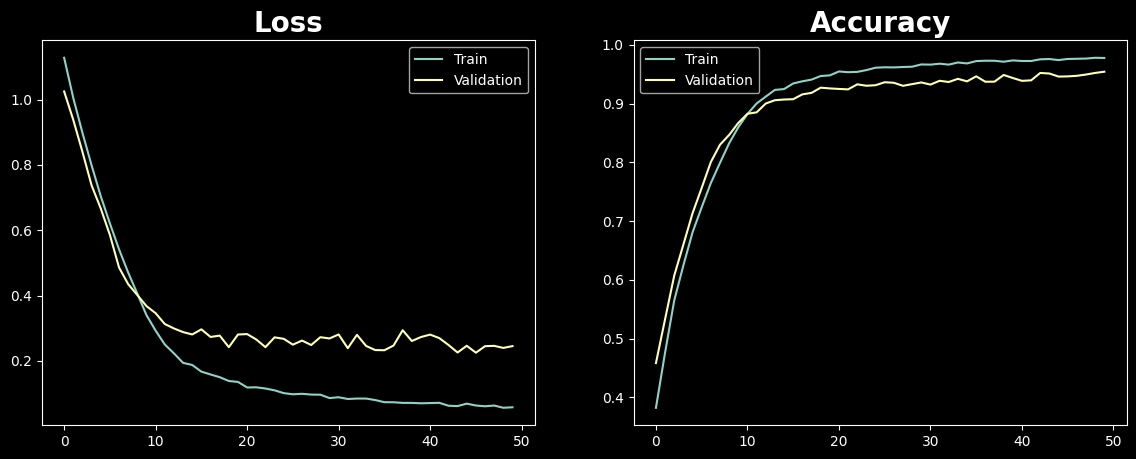

In [161]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(metrics[0],  label='Train')
ax1.plot(metrics[2],label='Validation')
ax1.set_title('Loss', fontsize=20, fontweight='bold')
ax1.legend()
ax2.plot(metrics[1], label='Train')
ax2.plot(metrics[3], label='Validation')
ax2.set_title('Accuracy', fontsize=20, fontweight='bold')
ax2.legend()

### Saving model parameters

In [9]:
torch.save({'model':model.state_dict(),
            'metrics':metrics},f'chkpt_class_{metrics[0][-1]:.3f}.pt')

### Loading saved model parameters and metrics

In [166]:
model.load_state_dict(torch.load('chkpt_class_0.058.pt')['model'])
metrics = torch.load('chkpt_class_0.058.pt')['metrics']

### Evaluation initialization

In [179]:
model.eval()       # setting model to evaluation mode
loss = nn.NLLLoss()
comp=[[],[]]       # label predictions

### Evaluation

In [180]:
with torch.no_grad():
    L, A = 0, 0
    for i,(img,label) in enumerate(tqdm(test_loader, desc = f'Evaluating: ', ncols = 100)):
        pred = model(img.to(device))
        L += loss(pred, label.to(device))
        A += a(torch.argmax(pred,1)-label.to(device))/len(pred)
        pred_lab = torch.argmax(pred, 1)
        comp[0].append(pred_lab.item())
        comp[1].append(label.item())
    print(f'\nLoss: {L.item()/(i+1)}\tAccuracy: {A/(i+1)}')

Evaluating: 100%|███████████████████████████████████████████████| 7500/7500 [02:36<00:00, 47.94it/s]


Loss: 1.9910391927083333	Accuracy: 0.6937333333333333


### Evaluation metrics

#### Confusion matrix

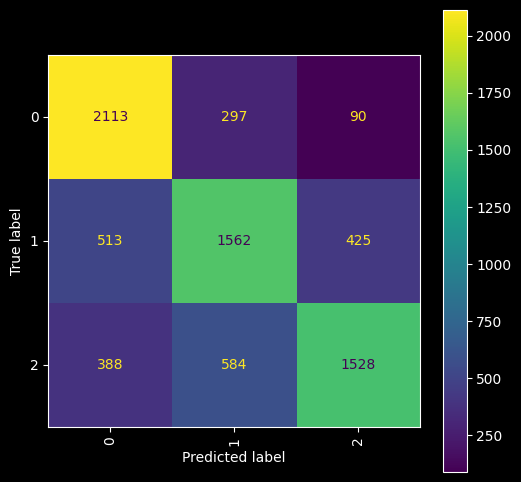

In [193]:
display = ConfusionMatrixDisplay(confusion_matrix(comp[1],comp[0]))
fig, ax = plt.subplots(figsize=(6,6))
display.plot(ax=ax, xticks_rotation="vertical")
plt.show()

#### ROC Curve and AUC Score

In [201]:
# one vs all splitting
pred_0_vs_all=[0 if i==0 else 1 for i in comp[0]]
pred_1_vs_all=[0 if i==1 else 1 for i in comp[0]]
pred_2_vs_all=[0 if i==2 else 1 for i in comp[0]]
orig_0_vs_all=[0 if i==0 else 1 for i in comp[1]]
orig_1_vs_all=[0 if i==1 else 1 for i in comp[1]]
orig_2_vs_all=[0 if i==2 else 1 for i in comp[1]]

#### no vs all

Area udner the ROC curve: 0.8324999999999999



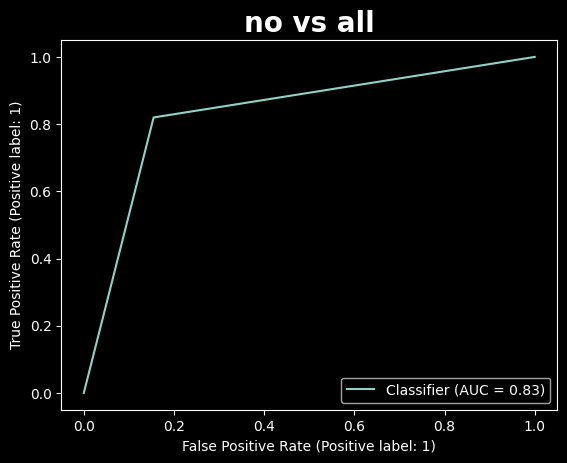

In [215]:
auc1 = roc_auc_score(orig_0_vs_all, pred_0_vs_all)
print(f'Area udner the ROC curve: {auc1}\n')
RocCurveDisplay.from_predictions(orig_0_vs_all,pred_0_vs_all)
plt.title('no vs all',fontsize=20,fontweight='bold')
plt.show()

#### sphere vs all

Area udner the ROC curve: 0.7242999999999999



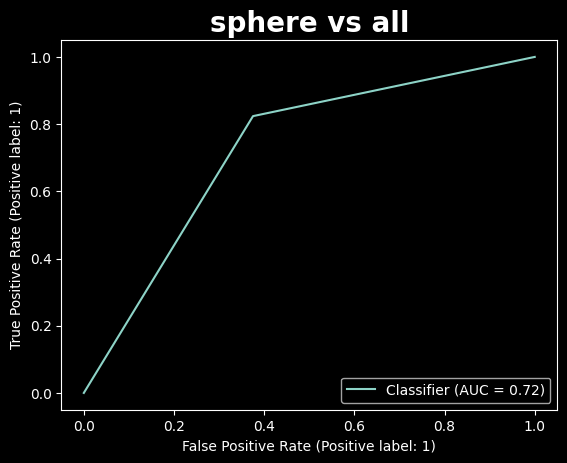

In [216]:
auc2 = roc_auc_score(orig_1_vs_all, pred_1_vs_all)
print(f'Area udner the ROC curve: {auc2}\n')
RocCurveDisplay.from_predictions(orig_1_vs_all,pred_1_vs_all)
plt.title('sphere vs all',fontsize=20,fontweight='bold')
plt.show()

#### vort vs all

Area udner the ROC curve: 0.7541



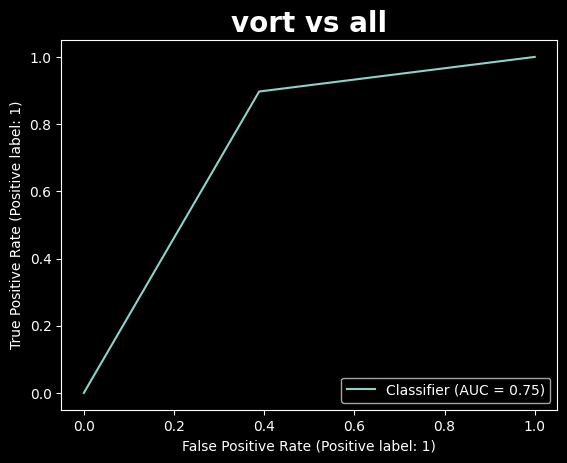

In [217]:
auc3 = roc_auc_score(orig_2_vs_all, pred_2_vs_all)
print(f'Area udner the ROC curve: {auc3}\n')
RocCurveDisplay.from_predictions(orig_2_vs_all,pred_2_vs_all)
plt.title('vort vs all',fontsize=20,fontweight='bold')
plt.show()

### Summary of Evaluation results

In [219]:
pd.DataFrame({'Classes':['no vs all', 'sphere vs all', 'vort vs all'],
              'AUC Score':[auc1, auc2, auc3]})

,Classes,AUC Score
0,no vs all,0.8325
1,sphere vs all,0.7243
2,vort vs all,0.7541
